In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
import ubelt as ub
import pint
site.addsitedir('../../../ARGUS')
from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd  #NOQA
Ureg = pint.UnitRegistry()

In [2]:
img1_dir = "../../Data_ONSD/Preprocessed/"
img2_dir = "../../Data_ONSD/Annotations/CLEANED/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_cropM.mha')))
all_labels = sorted(glob(os.path.join(img2_dir, '*.overlay.mha')))

num_devices = 1
gpu_device = 3
runs = 3

num_classes = 3

net_in_dims = 3 # Spatial Dimensions
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)
        
num_folds = 8

num_slice = 16
size_x = 320
size_y = 640

num_workers_te = 2
batch_size_te = 2

In [3]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

p_prefix = [
        ' 158',
        ' 64',
        ' 139',
        ' 87',
        ' 117',
        ' 130',
        ' 205',
        ' 209',
        ' 213'
    ]
n_prefix = [
        ' 23',
        ' 108',
        ' 119',
        ' 129',
        ' 163',
        ' 191',
        ' 228',
        ' 250'
    ]


fold_prefix_list = []
p_count = 0
n_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_p = 1
        num_n = 1
        if i > num_folds-2:
            num_p = 2
    else:
        num_p = 1
        num_n = 1
    f = []
    if p_count < len(p_prefix):
        for p in range(num_p):
            f.append([p_prefix[p_count+p]])
    p_count += num_p
    if n_count < len(n_prefix):
        for n in range(num_n):
            f.append([n_prefix[n_count+n]])
    n_count += num_n
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])

Num images / labels = 19 19
0 [[' 158'], [' 23']]
1 [[' 64'], [' 108']]
2 [[' 139'], [' 119']]
3 [[' 87'], [' 129']]
4 [[' 117'], [' 163']]
5 [[' 130'], [' 191']]
6 [[' 205'], [' 228']]
7 [[' 209'], [' 250']]


In [4]:
total_bytes = 0
for p in all_images:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

total_bytes = 0
for p in all_labels:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

0.831169568002224 gibibyte
0.004821689799427986 gibibyte


In [5]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    va_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    for f in range(i+num_folds-2, i+num_folds-1):
        va_folds.append(fold_prefix_list[f%num_folds])
    va_folds = list(np.concatenate(va_folds).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

13 2 3
12 3 3
13 3 2
14 2 2
14 2 2
14 2 2
14 2 2
14 2 2


In [6]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slice,
            center_slice=-num_slice/2 - 1,
            axis=3,
            require_labeled=True,
            reduce_to_statistics=[False,False],
            extended=False,
            include_center_slice=False,
            include_mean_abs_diff=False,
            keys=['image','label']),
        Resized(
            spatial_size=(-1,size_y,-1),
            mode=["trilinear","nearest"],
            keys=['image','label'],
        ),
        ToTensord(keys=["image", "label"])
    ]
)

In [7]:
device = torch.device("cpu")

In [14]:
model_type = "best"  #"best" or "last"

def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds - 1)

    for run in range(0,runs):
        experiment_type = '3D'
        model_filename_base = "./results/BAMC_ONSD-CLEANED_ARUNet-" + str(experiment_type) + "-yuriNerveData-" + str(num_slice) + "s-VFold-Run" + str(run)
        model_filename_base = model_filename_base+"/"
        model_file = model_filename_base+model_type+'_model.vfold_'+str(vfold_num)+'.pth'
        if os.path.exists(model_file):
            model = UNet(
                dimensions=net_in_dims,
                in_channels=net_in_channels,
                out_channels=num_classes,
                channels=net_channels,
                strides=net_strides,
                num_res_units=2,
                norm=Norm.BATCH,
        ).to(device)
            dice_metric = DiceMetric(include_background=False, reduction="mean")
            post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
            post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])   
            model.load_state_dict(torch.load(model_file))
            model.eval()

            with torch.no_grad():
                i = 0
                for b,test_data in enumerate(test_loader):
                    print(b)
                    print(test_data["image"].shape)
                    roi_size = (size_x, size_y,num_slice)
                    sw_batch_size = 1
                    test_outputs = sliding_window_inference(
                        test_data["image"].to(device), roi_size, sw_batch_size, model
                    )
                    test_labels = test_data["label"].to(device)
                    test_outputs_list = [post_pred(i) for i in decollate_batch(test_outputs)]
                    test_labels_list = [post_label(i) for i in decollate_batch(test_labels)]
                    dice_metric(y_pred=test_outputs_list, y=test_labels_list)
                    metric = dice_metric.aggregate().item()
                    print("Average test dice score for Vfold " + str(vfold_num) + " = " +str(metric))
                    dice_metric.reset()
                    if b > 0:
                        test_outputs_total = np.concatenate((test_outputs_total,test_outputs),axis=0)
                        test_images_total = np.concatenate((test_images_total,test_data["image"].to(device)),axis=0)
                        test_labels_total = np.concatenate((test_labels_total,test_data["label"].to(device)),axis=0)
                        i += 1
                    else:
                        test_outputs_total = test_outputs
                        test_images_total = test_data["image"].to(device)
                        test_labels_total = test_data["label"].to(device)

    nerve_prior = 1
    class_nerve = 1

    min_size = 60000
    max_size = 100000
    
    print("Output shape: " + str(test_outputs_total.shape))
    print("Images shape: " + str(test_images_total.shape))
    print("Labels shape: " + str(test_labels_total.shape))
    test_op = test_outputs_total[:,[0,2],:,:,:]
    print("Test_op shape: " + str(test_op.shape))

    for x in range(0,len(test_files[vfold_num])):
        print(test_files[vfold_num][x]["image"])
    for j in range(test_outputs_total.shape[0]):
        print("J = " + str(j))
        print("Filename: ")
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image")
        tmpV = test_images_total[j,0,:,:,7]
        plt.imshow(tmpV, cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label")
        tmpV = test_labels_total[j,0,:,:,7]
        tmpV[0,0]=0
        tmpV[0,1]=1
        plt.imshow(tmpV)
        plt.subplot(1, 3, 3)
        plt.title(f"output")
        prob_shape = test_outputs_total[j,[0,2],:,:,:].shape
        prob = np.empty(prob_shape)
        prob_total = 0
        for run in range(0,runs):
            for c in range(num_classes - 1):
                itkProb = itk.GetImageFromArray(test_op[j,c,:,:,:])
                imMathProb = ttk.ImageMath.New(itkProb)
                imMathProb.Blur(5)
                itkProb = imMathProb.GetOutput()
                prob[c] = itk.GetArrayFromImage(itkProb)
            class_array = np.zeros(prob[0].shape)
            pmin = prob[0].min()
            pmax = prob[0].max()
            for c in range(1,num_classes - 1):
                pmin = min(pmin, prob[c].min())
                pmax = max(pmax, prob[c].max())
            prange = pmax - pmin
            prob = (prob - pmin) / prange
            prob[class_nerve] = prob[class_nerve] * nerve_prior
            done = False
            while not done:
                done = True
                count = np.count_nonzero(class_array>0)
                while count<min_size:
                    prob[class_nerve] = prob[class_nerve] * 1.05
                    class_array = np.argmax(prob,axis=0)
                    count = np.count_nonzero(class_array>0)
                    done = False
                while count>max_size:
                    prob[class_nerve] = prob[class_nerve] * 0.95
                    class_array = np.argmax(prob,axis=0)
                    count = np.count_nonzero(class_array>0)
                    done = False
            denom = (prob[class_nerve] + prob[0])
            denom = np.where(denom==0,1,denom)
            prob_total += (prob[class_nerve]/denom)
            
        prob_total = prob_total / runs
        class_array = np.where(prob_total>0.5,1,0)
        class_image = itk.GetImageFromArray(class_array.astype(np.float32))
        imMathClassCleanup = ttk.ImageMath.New(class_image)
        imMathClassCleanup.Erode(5,class_nerve,0)
        imMathClassCleanup.Dilate(5,class_nerve,0)
        class_output = imMathClassCleanup.GetOutputUChar()
        
        seg = itk.itkARGUS.SegmentConnectedComponents.New(Input=class_output)
        seg.SetKeepOnlyLargestComponent(True)
        seg.Update()

        class_output = seg.GetOutput()
        class_output_array = itk.GetArrayFromImage(class_output)
        test_label = test_labels_total[j,0,:,:,:]
        class_label = test_label
        tmpV[0,0]=0
        tmpV[0,1]=1
        class_output_array[0,0]=0
        class_output_array[0,1]=1
        plt.imshow(class_output_array[:,:,7])
        plt.show()


Loading dataset: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]

VFOLD = 0 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 0 = 0.526549756526947
1
torch.Size([1, 1, 661, 640, 16])
Average test dice score for Vfold 0 = 0.3680770695209503


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 0 = 0.37254369258880615
1
torch.Size([1, 1, 661, 640, 16])
Average test dice score for Vfold 0 = 0.2626195251941681


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 0 = 0.38975387811660767
1
torch.Size([1, 1, 661, 640, 16])
Average test dice score for Vfold 0 = 0.148103266954422
Output shape: (3, 3, 661, 640, 16)
Images shape: (3, 1, 661, 640, 16)
Labels shape: (3, 1, 661, 640, 16)
Test_op shape: (3, 2, 661, 640, 16)
../../Data_ONSD/Preprocessed/10. 250.1 Left Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/3. 250.1 Right Lat_Video 2_cropM.mha
../../Data_ONSD/Preprocessed/9. 209.1 Left_Long_Video 1_cropM.mha
J = 0
Filename: 


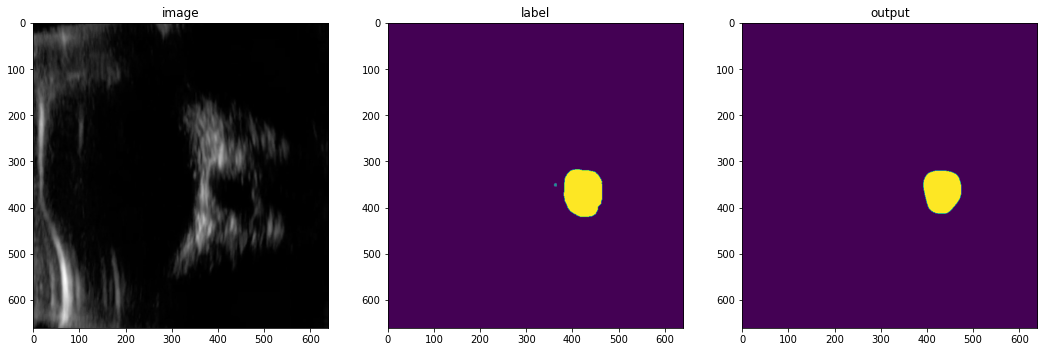

J = 1
Filename: 


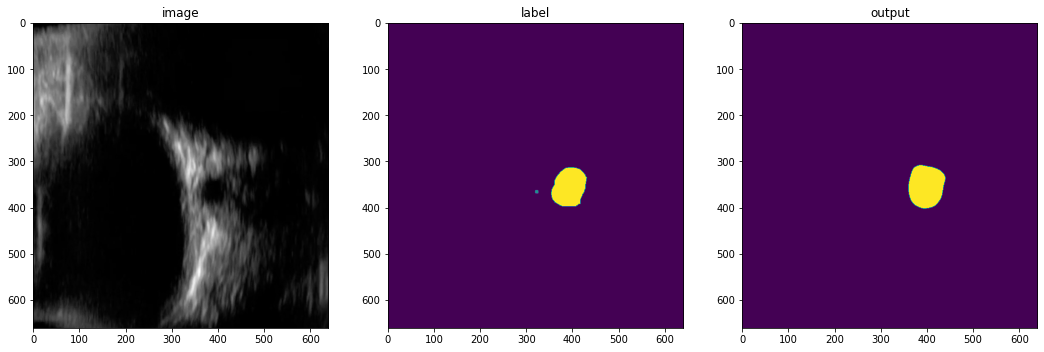

J = 2
Filename: 


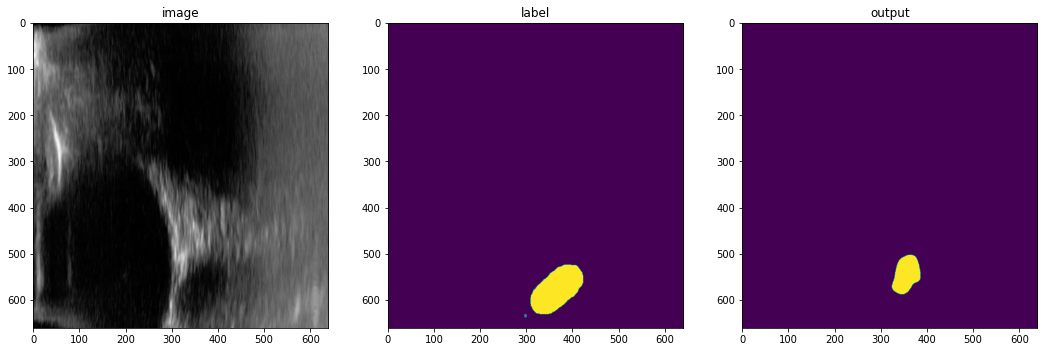

Loading dataset: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

VFOLD = 1 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 1 = 0.42273858189582825
1
torch.Size([1, 1, 661, 640, 16])
Average test dice score for Vfold 1 = 0.27391862869262695


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 1 = 0.43351373076438904
1
torch.Size([1, 1, 661, 640, 16])
Average test dice score for Vfold 1 = 0.3746788203716278


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 1 = 0.15957768261432648
1
torch.Size([1, 1, 661, 640, 16])
Average test dice score for Vfold 1 = 0.3181211054325104
Output shape: (3, 3, 661, 640, 16)
Images shape: (3, 1, 661, 640, 16)
Labels shape: (3, 1, 661, 640, 16)
Test_op shape: (3, 2, 661, 640, 16)
../../Data_ONSD/Preprocessed/2. 158.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 23.1 Right_Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/8. 23.1 Left_Lat_Video 2_cropM.mha
J = 0
Filename: 


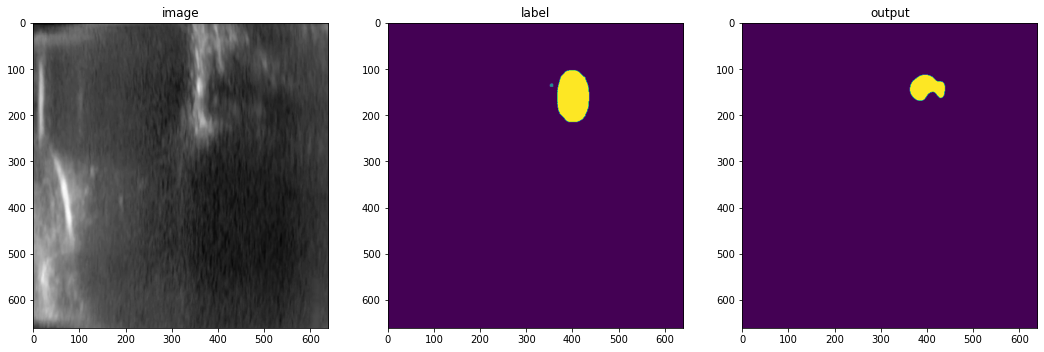

J = 1
Filename: 


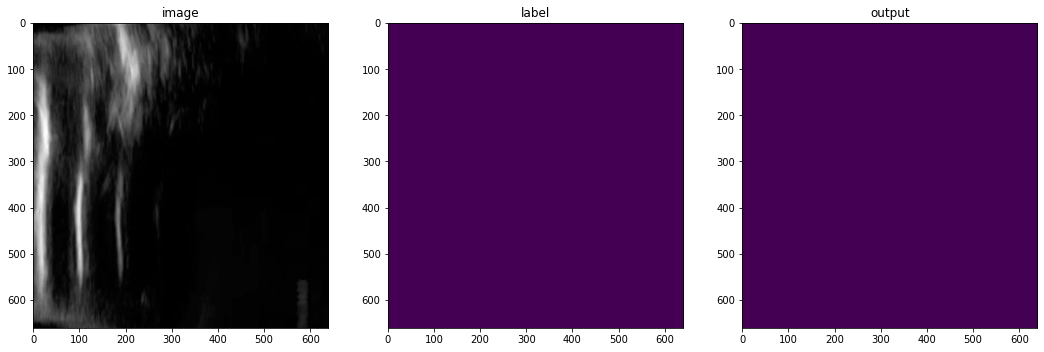

J = 2
Filename: 


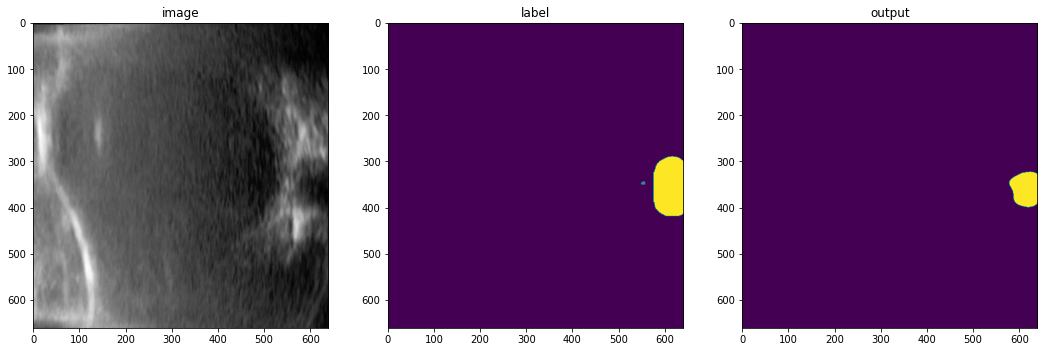

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

VFOLD = 2 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 2 = 0.3363439440727234


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 2 = 0.295001745223999


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 2 = 0.4142800271511078
Output shape: torch.Size([2, 3, 661, 640, 16])
Images shape: torch.Size([2, 1, 661, 640, 16])
Labels shape: torch.Size([2, 1, 661, 640, 16])
Test_op shape: torch.Size([2, 2, 661, 640, 16])
../../Data_ONSD/Preprocessed/2. 64.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/7. 108.1 Left_Lat_Video 1_cropM.mha
J = 0
Filename: 


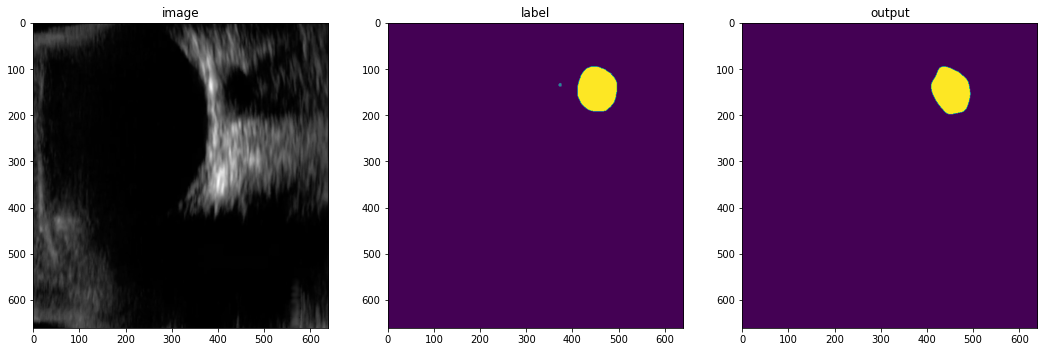

J = 1
Filename: 


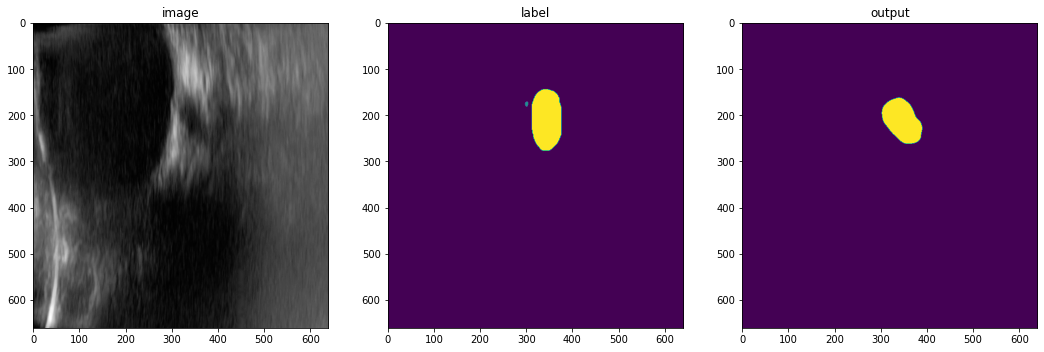

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

VFOLD = 3 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 3 = 0.3467276692390442


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 3 = 0.35204923152923584


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 3 = 0.30401644110679626
Output shape: torch.Size([2, 3, 661, 640, 16])
Images shape: torch.Size([2, 1, 661, 640, 16])
Labels shape: torch.Size([2, 1, 661, 640, 16])
Test_op shape: torch.Size([2, 2, 661, 640, 16])
../../Data_ONSD/Preprocessed/2. 119.1 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/4. 139.1 Right Long_Video 1_cropM.mha
J = 0
Filename: 


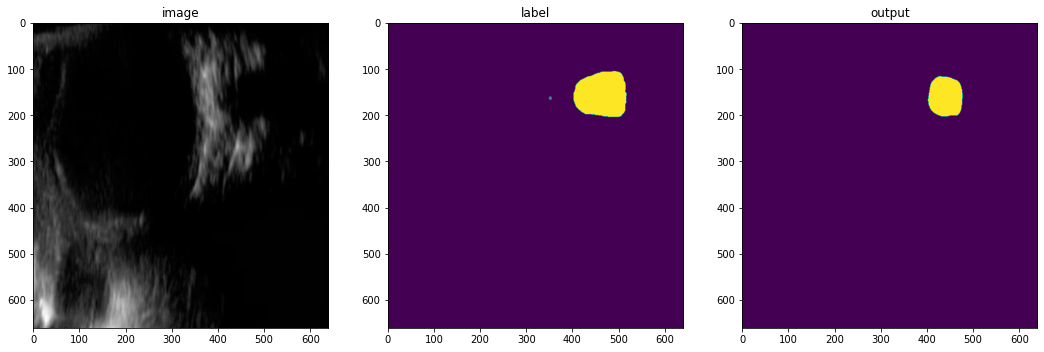

J = 1
Filename: 


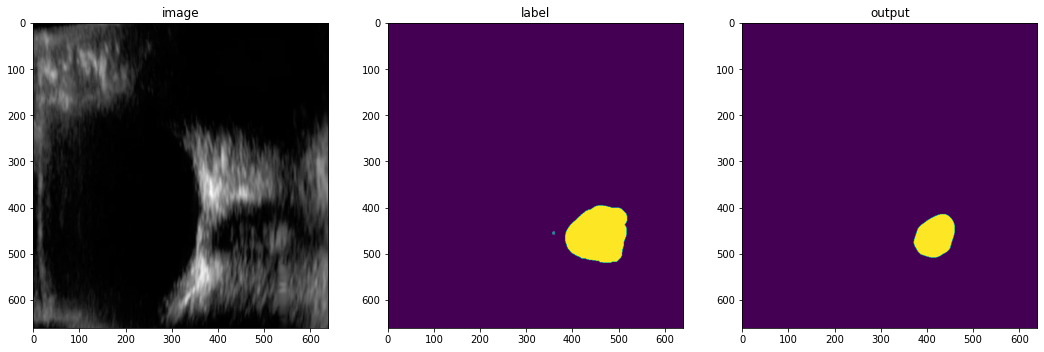

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

VFOLD = 4 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 4 = 0.128820538520813


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 4 = 0.29491883516311646


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 4 = 0.3118358254432678
Output shape: torch.Size([2, 3, 661, 640, 16])
Images shape: torch.Size([2, 1, 661, 640, 16])
Labels shape: torch.Size([2, 1, 661, 640, 16])
Test_op shape: torch.Size([2, 2, 661, 640, 16])
../../Data_ONSD/Preprocessed/4. 87.2 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 129.1 Left_Lat_Video 1_cropM.mha
J = 0
Filename: 


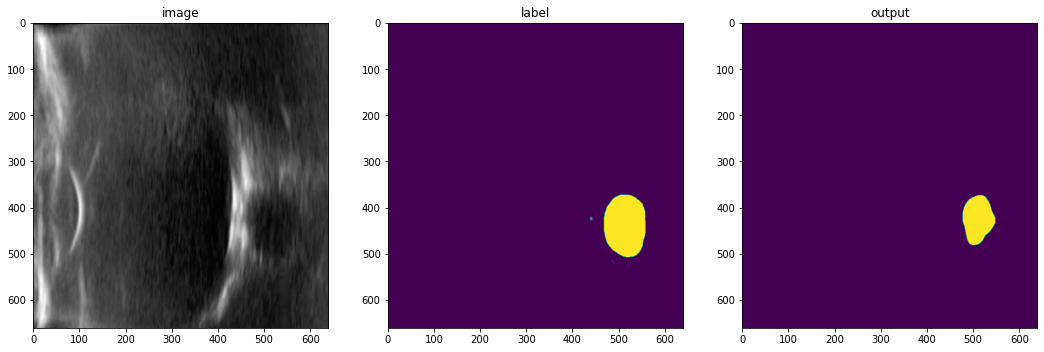

J = 1
Filename: 


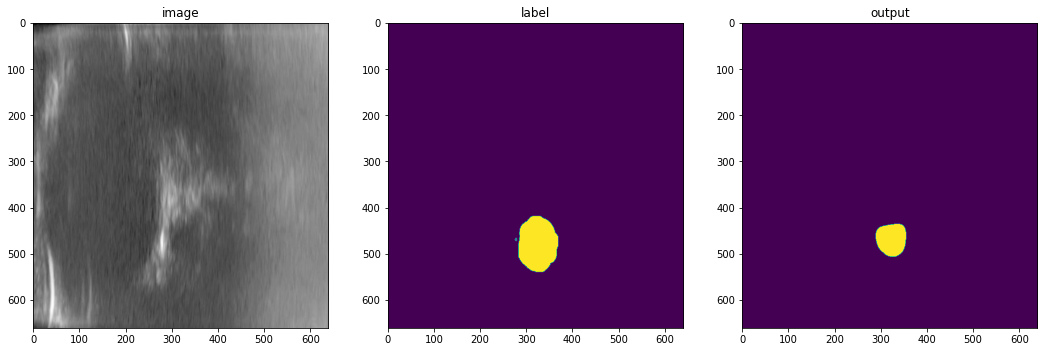

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]

VFOLD = 5 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 5 = 0.11726480722427368


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 5 = 0.22092849016189575


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 5 = 0.18695905804634094
Output shape: torch.Size([2, 3, 661, 640, 16])
Images shape: torch.Size([2, 1, 661, 640, 16])
Labels shape: torch.Size([2, 1, 661, 640, 16])
Test_op shape: torch.Size([2, 2, 661, 640, 16])
../../Data_ONSD/Preprocessed/2. 163.2 Right_Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/6. 117.1 Left Lat_Video 1_cropM.mha
J = 0
Filename: 


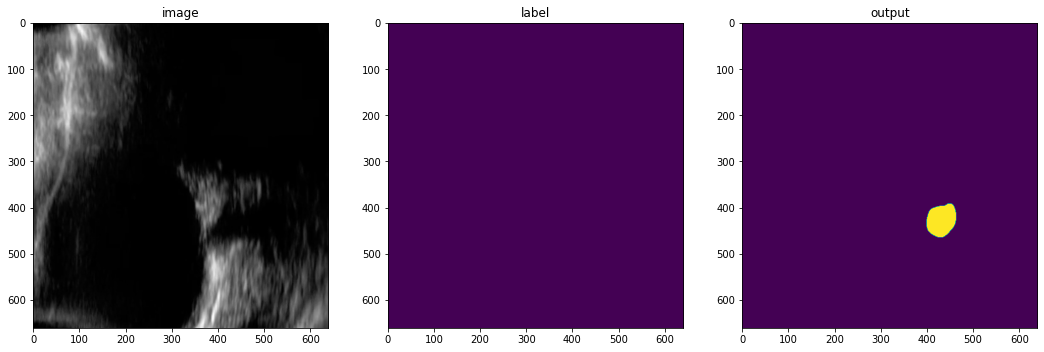

J = 1
Filename: 


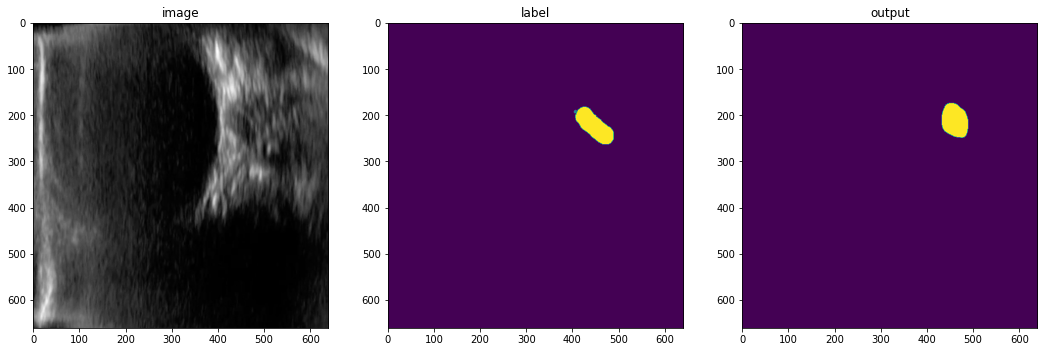

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

VFOLD = 6 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 6 = 0.3084091544151306


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 6 = 0.359741747379303


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 6 = 0.3095892071723938
Output shape: torch.Size([2, 3, 661, 640, 16])
Images shape: torch.Size([2, 1, 661, 640, 16])
Labels shape: torch.Size([2, 1, 661, 640, 16])
Test_op shape: torch.Size([2, 2, 661, 640, 16])
../../Data_ONSD/Preprocessed/4. 191.1 Right Long_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/7. 130.1 Left_Lat_Video 2_cropM.mha
J = 0
Filename: 


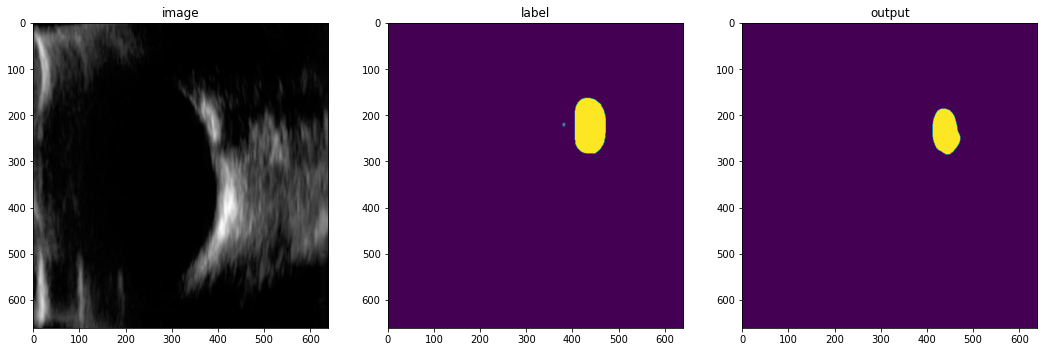

J = 1
Filename: 


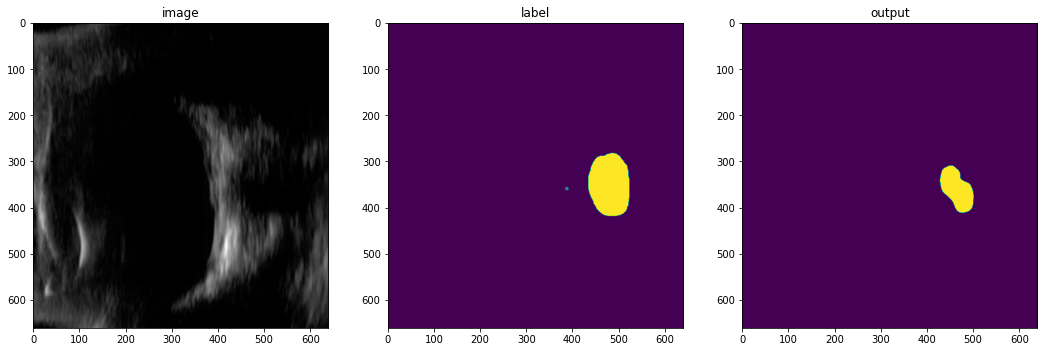

Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

VFOLD = 7 of 7



Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 7 = 0.2453094720840454


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 7 = 0.3145100176334381


Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 1, 661, 640, 16])
Average test dice score for Vfold 7 = 0.17903262376785278
Output shape: torch.Size([2, 3, 661, 640, 16])
Images shape: torch.Size([2, 1, 661, 640, 16])
Labels shape: torch.Size([2, 1, 661, 640, 16])
Test_op shape: torch.Size([2, 2, 661, 640, 16])
../../Data_ONSD/Preprocessed/2. 228.1 Right Lat_Video 1_cropM.mha
../../Data_ONSD/Preprocessed/8. 205.1 Left Long_Video 1_cropM.mha
J = 0
Filename: 


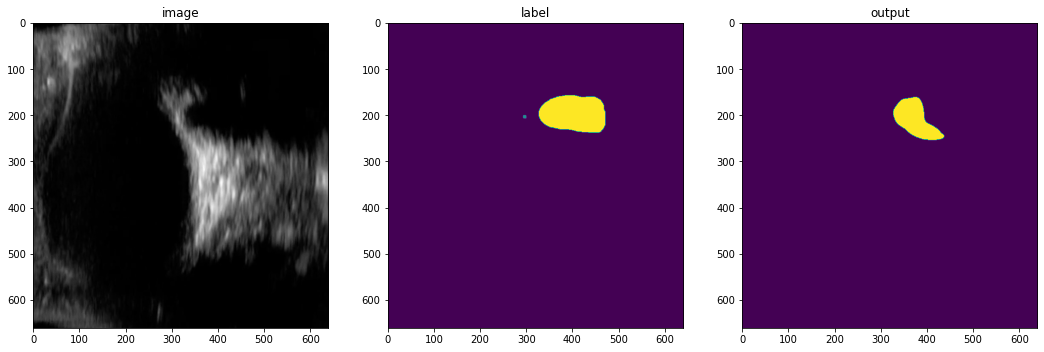

J = 1
Filename: 


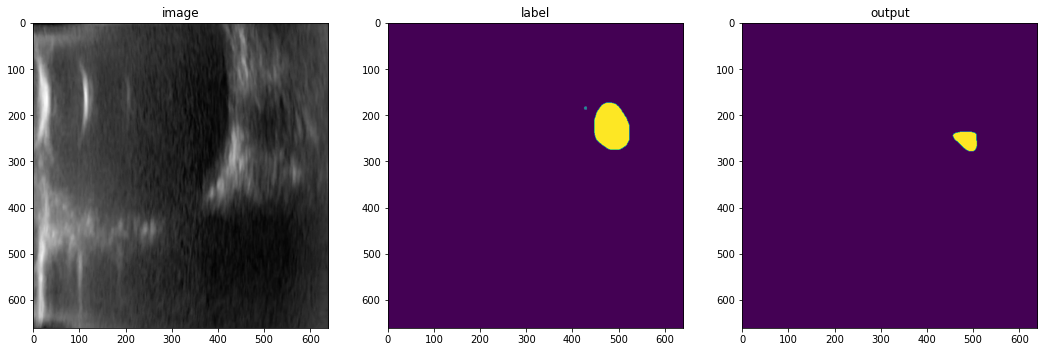

In [15]:
for i in range(0,num_folds,num_devices):
    test_ds = CacheDataset(data=test_files[i], transform=test_transforms,cache_rate=1.0, num_workers=num_workers_te)
    test_loader = DataLoader(test_ds, batch_size=batch_size_te, num_workers=num_workers_te)
    plot_vfold_training_curves(i,test_loader)
    test_loader.dataset._cache.clear()


In [16]:
import ipyparams
currentNotebook = "EnsembleClassPriorsTest-CLEANED-3D_RawFrame-320x640-16s.ipynb"
exp = "EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s"

from datetime import datetime
now = datetime.now()
print(str(currentNotebook))
experimentName = exp+now.strftime("-%Y.%m.%d_%H.%M")
print(experimentName)
cmd = "jupyter nbconvert "+currentNotebook+" --output "+experimentName+" --to pdf"
import subprocess
subprocess.call(cmd, shell=True)

<IPython.core.display.Javascript object>

EnsembleClassPriorsTest-CLEANED-3D_RawFrame-320x640-16s.ipynb
EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.01_11.14


[NbConvertApp] Converting notebook EnsembleClassPriorsTest-CLEANED-3D_RawFrame-320x640-16s.ipynb to pdf
[NbConvertApp] Support files will be in EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.01_11.14_files/
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.01_11.14_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.01_11.14_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.01_11.14_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.01_11.14_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640-16s-2022.08.01_11.14_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-ONSD-CLEANED-3D_RawFrame-LabelTrue-320x640

0